## WGAN-gp (Wasserstein GAN gradient penalty)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
from tqdm import tqdm, tqdm_notebook
import glob
import shutil
import time      # time.perf_counter()
import random

import matplotlib.pyplot as plt
import cv2

import xml.etree.ElementTree as ET

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# try:
#   os.mkdir('/root/.kaggle')
# except:
#   pass

# f=open('/root/.kaggle/kaggle.json','w')
# f.write('{"username":"vivianroshan","key":"2090a4631d87564c16cdb6e361e3e83c"}')
# f.close()

# !chmod 600 '/root/.kaggle/kaggle.json'

# # print('Tensorflow version:', tf.__version__)
# !kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

# !rm -rf 'images'
# !unzip 'satellite-images-of-water-bodies.zip' -d '/content/data'
# !cp -r '/content/data/Water Bodies Dataset/Images' '/content/images'
# !rm -rf '/content/data'
# !rm 'satellite-images-of-water-bodies.zip'

In [3]:
# print(os.listdir("../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images"))

## Constants

In [4]:
kernel_start = time.perf_counter()
kernel_time_limit = 60*60*8.5        #### running time

# image size
img_size = 64
channels = 3
img_shape = (img_size, img_size, channels)    # (64,64,3)

# z(latent variable) size
z_dim = 100
z_shape = (z_dim,)

# gradient penalty coefficient "λ"
penaltyLambda = 10    # d_loss = f_loss - r_loss + λ･penalty

# critic(discriminator) iterations per generator iteration
trainRatio = 5

batch_size = 32        # 16 or 64 better?
rec_interval = 100

DIR = os.getcwd()
DIRimg = "../input/satellite-images-of-water-bodies"
# DIRanno = "."
DIRout = "output"

In [5]:
!pwd

/kaggle/working


## Convert Images to Train Data

In [6]:
# train data
wb_images=os.listdir('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images')
Dir='../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images'

x_train = np.zeros((len(wb_images),img_size,img_size,3))
for i in tqdm(range(len(wb_images))):
    path = os.path.join(Dir, wb_images[i])
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(img_size,img_size))
    x_train[i] = img

x_train = x_train / 255
print(x_train.shape)

100%|██████████| 2841/2841 [00:33<00:00, 84.61it/s] 


(2841, 64, 64, 3)


## Image samples input

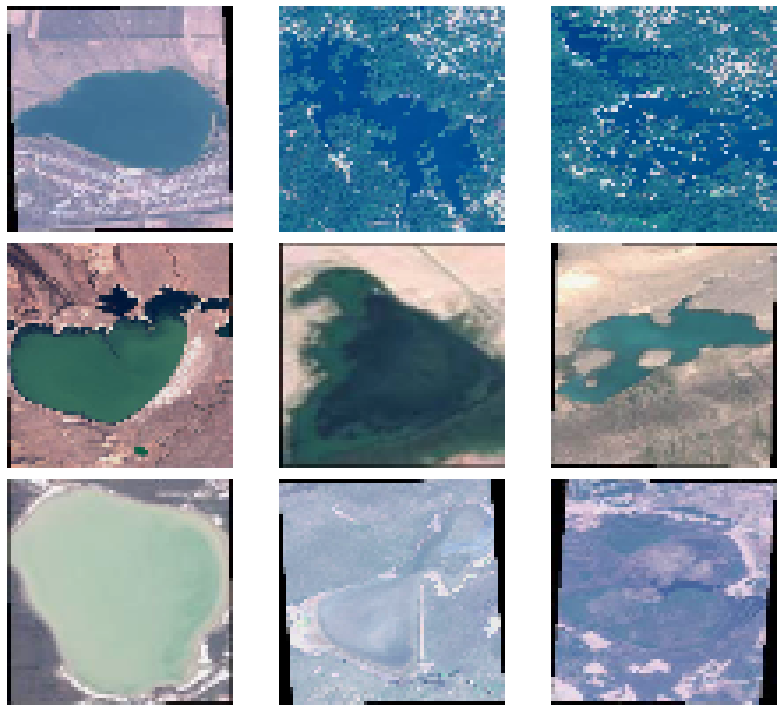

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
sample_ids=np.random.randint(0,x_train.shape[0],9)

for indx, axis in enumerate(axes.flatten()):
    img = image.array_to_img(x_train[sample_ids[indx]])    # ndarray → PIL
    imgplot = axis.imshow(img)
    axis.set_axis_off()
plt.tight_layout()

# Input images ( land )

100%|██████████| 2500/2500 [00:22<00:00, 111.36it/s]


xtrain_land(2500, 64, 64, 3)


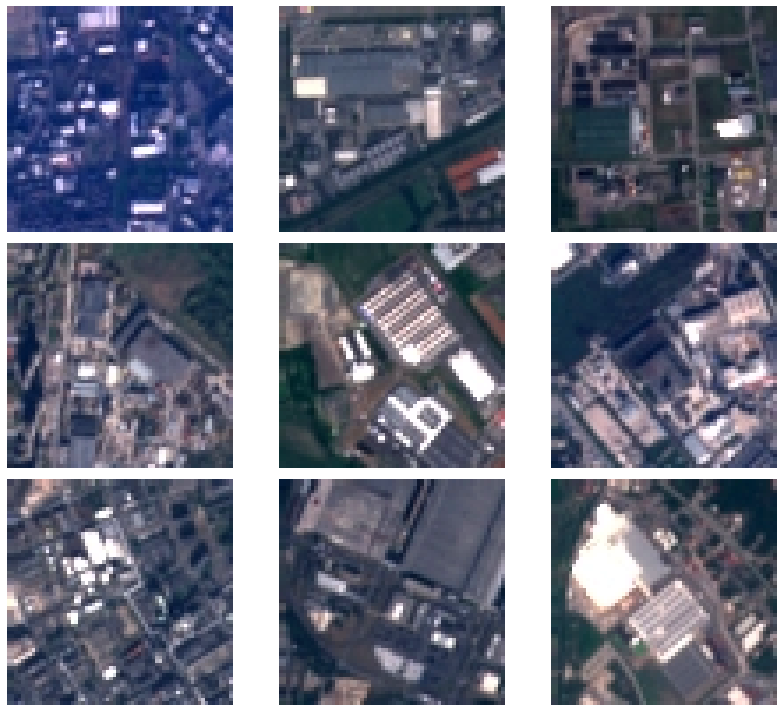

In [8]:
#land images
land_images_dir='../input/eurosat-rgb/2750/Industrial'
land_images=os.listdir(land_images_dir)

x_train_land = np.zeros((len(land_images),img_size,img_size,3))
for i in tqdm(range(len(land_images))):
    path = os.path.join(land_images_dir,land_images[i])
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(img_size,img_size))
    x_train_land[i] = img

x_train_land = x_train_land / 255
print('xtrain_land'+str(x_train_land.shape))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
sample_ids=np.random.randint(0,x_train_land.shape[0],9)

for indx, axis in enumerate(axes.flatten()):
    img = image.array_to_img(x_train_land[sample_ids[indx]])    # ndarray → PIL
    imgplot = axis.imshow(img)
    axis.set_axis_off()
plt.tight_layout()


# Input images (water)

100%|██████████| 2500/2500 [00:22<00:00, 111.47it/s]


xtrain_water:(2500, 64, 64, 3)


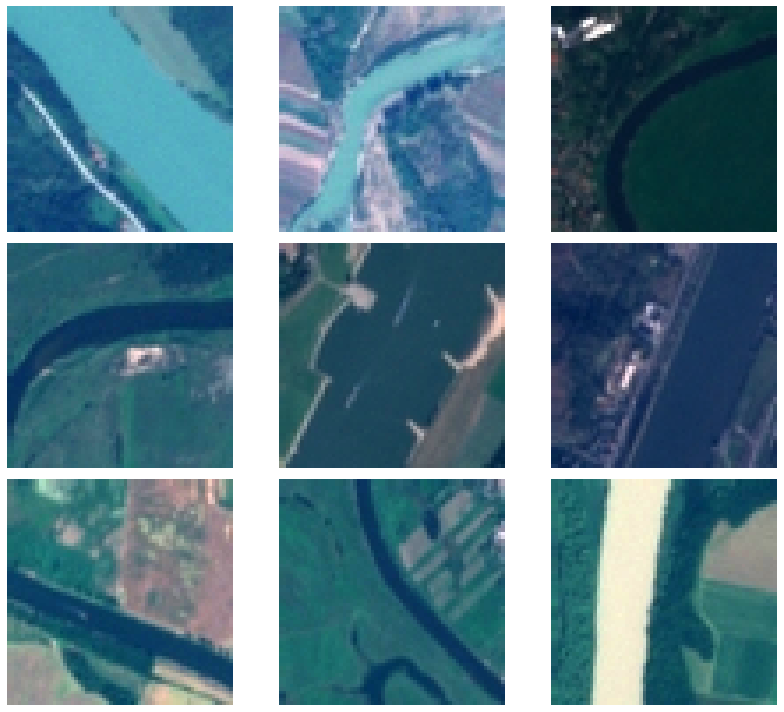

In [9]:
#water bodies images
water_images_dir='../input/eurosat-rgb/2750/River'
water_images=os.listdir(water_images_dir)

x_train_water = np.zeros((len(water_images),img_size,img_size,3))
for i in tqdm(range(len(water_images))):
    path = os.path.join(water_images_dir,water_images[i])
    img=cv2.imread(path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(img_size,img_size))
    x_train_water[i] = img

x_train_water = x_train_water / 255
print('xtrain_water:'+str(x_train_water.shape))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))
sample_ids=np.random.randint(0,x_train_water.shape[0],9)

for indx, axis in enumerate(axes.flatten()):
    img = image.array_to_img(x_train_water[sample_ids[indx]])    # ndarray → PIL
    imgplot = axis.imshow(img)
    axis.set_axis_off()
plt.tight_layout()

## WGAN-gp Model

In [10]:
def build_generator():
    input = Input(shape=z_shape)
    x = Dense(8*img_size*img_size, activation="relu")(input)
    x = Reshape((img_size//8, img_size//8, -1))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*4, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same",
               use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*2, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same",
                   use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x,training=1)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5, )(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(64*1, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x, training=1)
    x = Activation("relu")(x)
    x = Conv2D(3, kernel_size=3, strides=1, padding="same", activation="tanh",
               use_bias=False,)(x)

    model = Model(input, x)
    print("●generator")
    model.summary()
    return model

In [11]:
def build_discriminator():
    input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(input)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(1, kernel_size=1, strides=1, padding="same", use_bias=False)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation=None)(x)   # activation = None
    
    model = Model(input, x)
    print("●discriminator")
    model.summary()
    return model

In [12]:
def build_WGANgp(generator, discriminator):
    #### model
    # generator image(fake image)
    z = Input(shape=z_shape)
    f_img = generator(z)
    f_out = discriminator(f_img)
    # real image
    r_img = Input(shape=img_shape)
    r_out = discriminator(r_img)
    # average image
    epsilon = K.placeholder(shape=(None,1,1,1))
    a_img = Input(shape=(img_shape),
                  tensor = epsilon * r_img + (1-epsilon) * f_img)
    a_out = discriminator(a_img)

    #### loss
    # original critic(discriminator) loss
    r_loss = K.mean(r_out)
    f_loss = K.mean(f_out)
    # gradient penalty  <this is point of WGAN-gp>
    grad_mixed = K.gradients(a_out, [a_img])[0]
    norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
    grad_penalty = K.mean(K.square(norm_grad_mixed -1))
    penalty = penaltyLambda * grad_penalty
    # d loss
    d_loss = f_loss - r_loss + penalty
    
    #### discriminator update function
    d_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9).get_updates(params=discriminator.trainable_weights,loss=d_loss)
    d_train = K.function([r_img, z, epsilon],
                         [r_loss, f_loss, penalty, d_loss],
                         d_updates)
    
    #### generator update function
    g_loss = -1. * f_loss
    g_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9).get_updates(params=generator.trainable_weights,loss=g_loss)
    g_train = K.function([z], [g_loss], g_updates)

    return g_train, d_train

## Build Training Model

In [13]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

## Prepare Training

In [14]:
# fixed z for confirmation of generated image
z_fix = np.random.normal(0, 1, (64, z_dim)) 

# list for store learning progress data
g_loss_list = []
r_loss_list = []
f_loss_list = []
f_r_loss_list = []
penalty_list = []
d_loss_list = []

# (0～1) → (-1～+1)


In [15]:
def sumple_images(imgs, rows=3, cols=3, figsize=(12,10)):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    for indx, axis in enumerate(axes.flatten()):
        img = image.array_to_img(imgs[indx])    # ndarray → PIL
        imgplot = axis.imshow(img)
        axis.set_axis_off()
    plt.tight_layout()

## Perform Training

In [16]:
def train(X_train,iterations=200):
    X_train = (X_train.astype(np.float32) - 0.5) / 0.5
    iteration = 0
    while time.perf_counter() - kernel_start < kernel_time_limit:

        #### Discriminator
        for j in range(trainRatio):
            # Generator in
            z = np.random.normal(0, 1, (batch_size, z_dim))
            # Generator out Images
            f_imgs = generator.predict(z)
            # Real Images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            r_imgs = X_train[idx]
            # train the discriminator
            epsilon = np.random.uniform(size = (batch_size, 1,1,1))
            r_loss, f_loss, penalty, d_loss = D_train([r_imgs, z, epsilon])

        #### Generator
        # Generator in
        z = np.random.normal(0, 1, (batch_size, z_dim))
        # train the generator
        g_loss = G_train([z])

        #### Record of learning progress
        # loss
        r_loss_list.append(r_loss)
        f_loss_list.append(f_loss)
        f_r_loss_list.append(f_loss - r_loss)
        penalty_list.append(penalty)
        d_loss_list.append(d_loss)
        # generated image sumple
        if (iteration in [100, 1000]) or (iteration % rec_interval == 0):
            print(f'iteration:{iteration} / d_loss:{d_loss:.3f} / g_loss:{sum(g_loss)/len(g_loss):.3f}')
            g_imgs = generator.predict(z_fix)
            imgs = g_imgs * 127.5 + 127.5
            sumple_images(imgs, rows=1, cols=7)
            plt.show()

        iteration += 1
        if iteration>iterations:
            break

    print("last iteration:",iteration - 1)
    # plot loss
    fig, ax = plt.subplots(5, 2, figsize=(20,30))
    for j in range(2):
        ax[0,j].plot(r_loss_list, label="r_los")
        ax[1,j].plot(f_loss_list, label="f_loss")
        ax[2,j].plot(f_r_loss_list, label="f-r_loss")
        ax[3,j].plot(penalty_list, label="penalty")
        ax[4,j].plot(d_loss_list, label="d_loss")
    for i in range(5):
        ax[i,0].set_xlim([0,200])
        ax[i,1].set_xlim([200,iteration])
        for j in range(2):
            ax[i,j].grid()
            ax[i,j].legend()
    plt.show()

●generator
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 32768)             3309568   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       1179648   
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)  

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


iteration:0 / d_loss:5.934 / g_loss:4.021


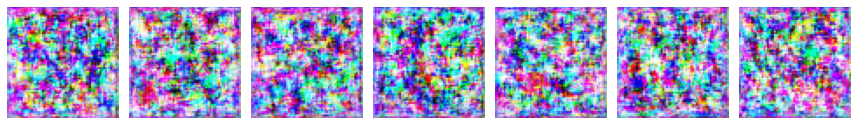

iteration:100 / d_loss:-17.097 / g_loss:19.233


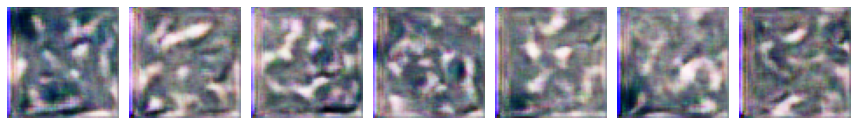

iteration:200 / d_loss:-4.259 / g_loss:4.215


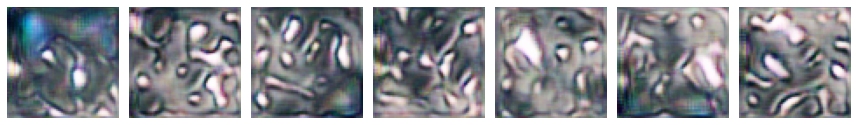

last iteration: 200


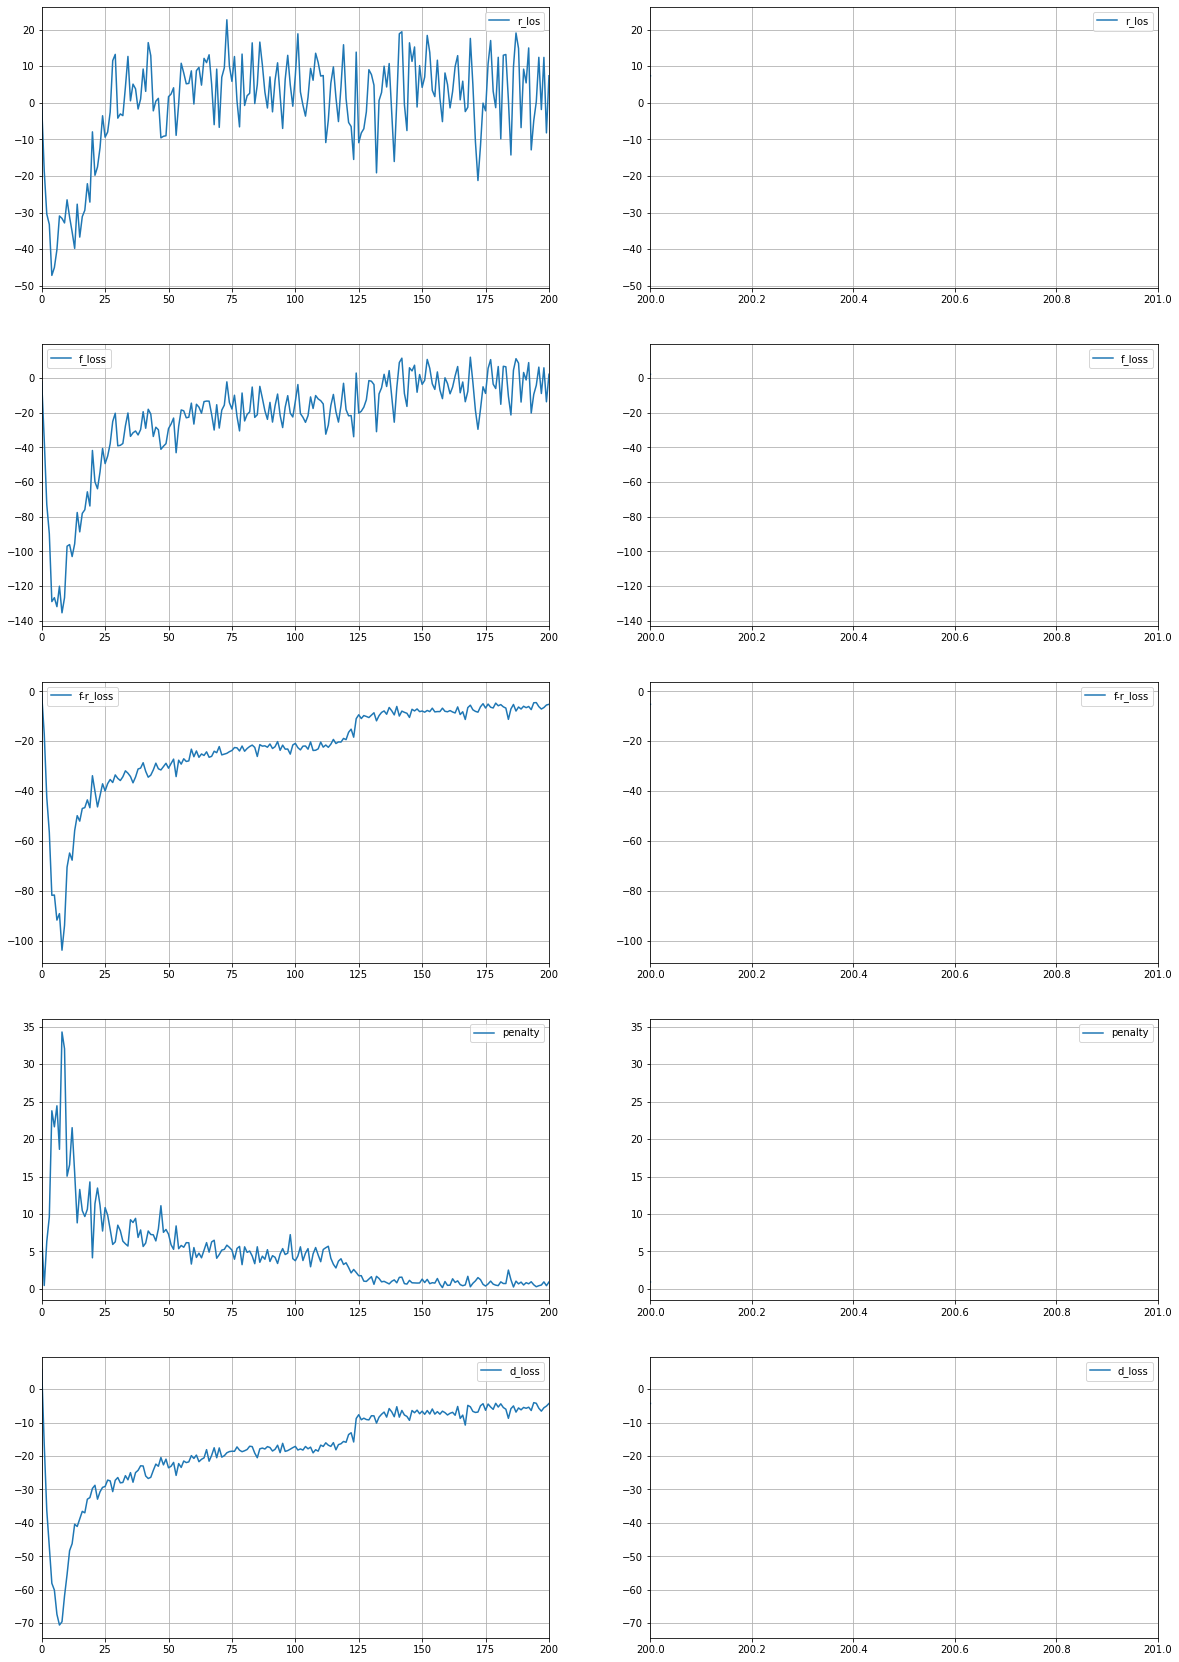

In [17]:
generator = build_generator()
discriminator = build_discriminator()
G_train, D_train = build_WGANgp(generator, discriminator)
train(x_train_land)

●generator
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 256)       1179648   
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 256)

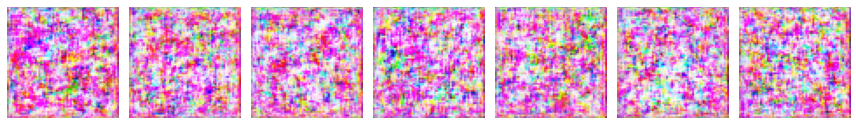

iteration:100 / d_loss:-7.103 / g_loss:0.351


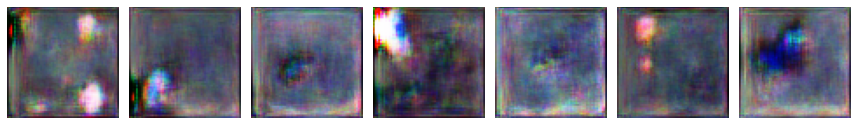

iteration:200 / d_loss:-4.812 / g_loss:-3.829


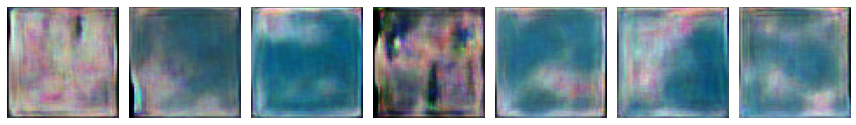

last iteration: 200


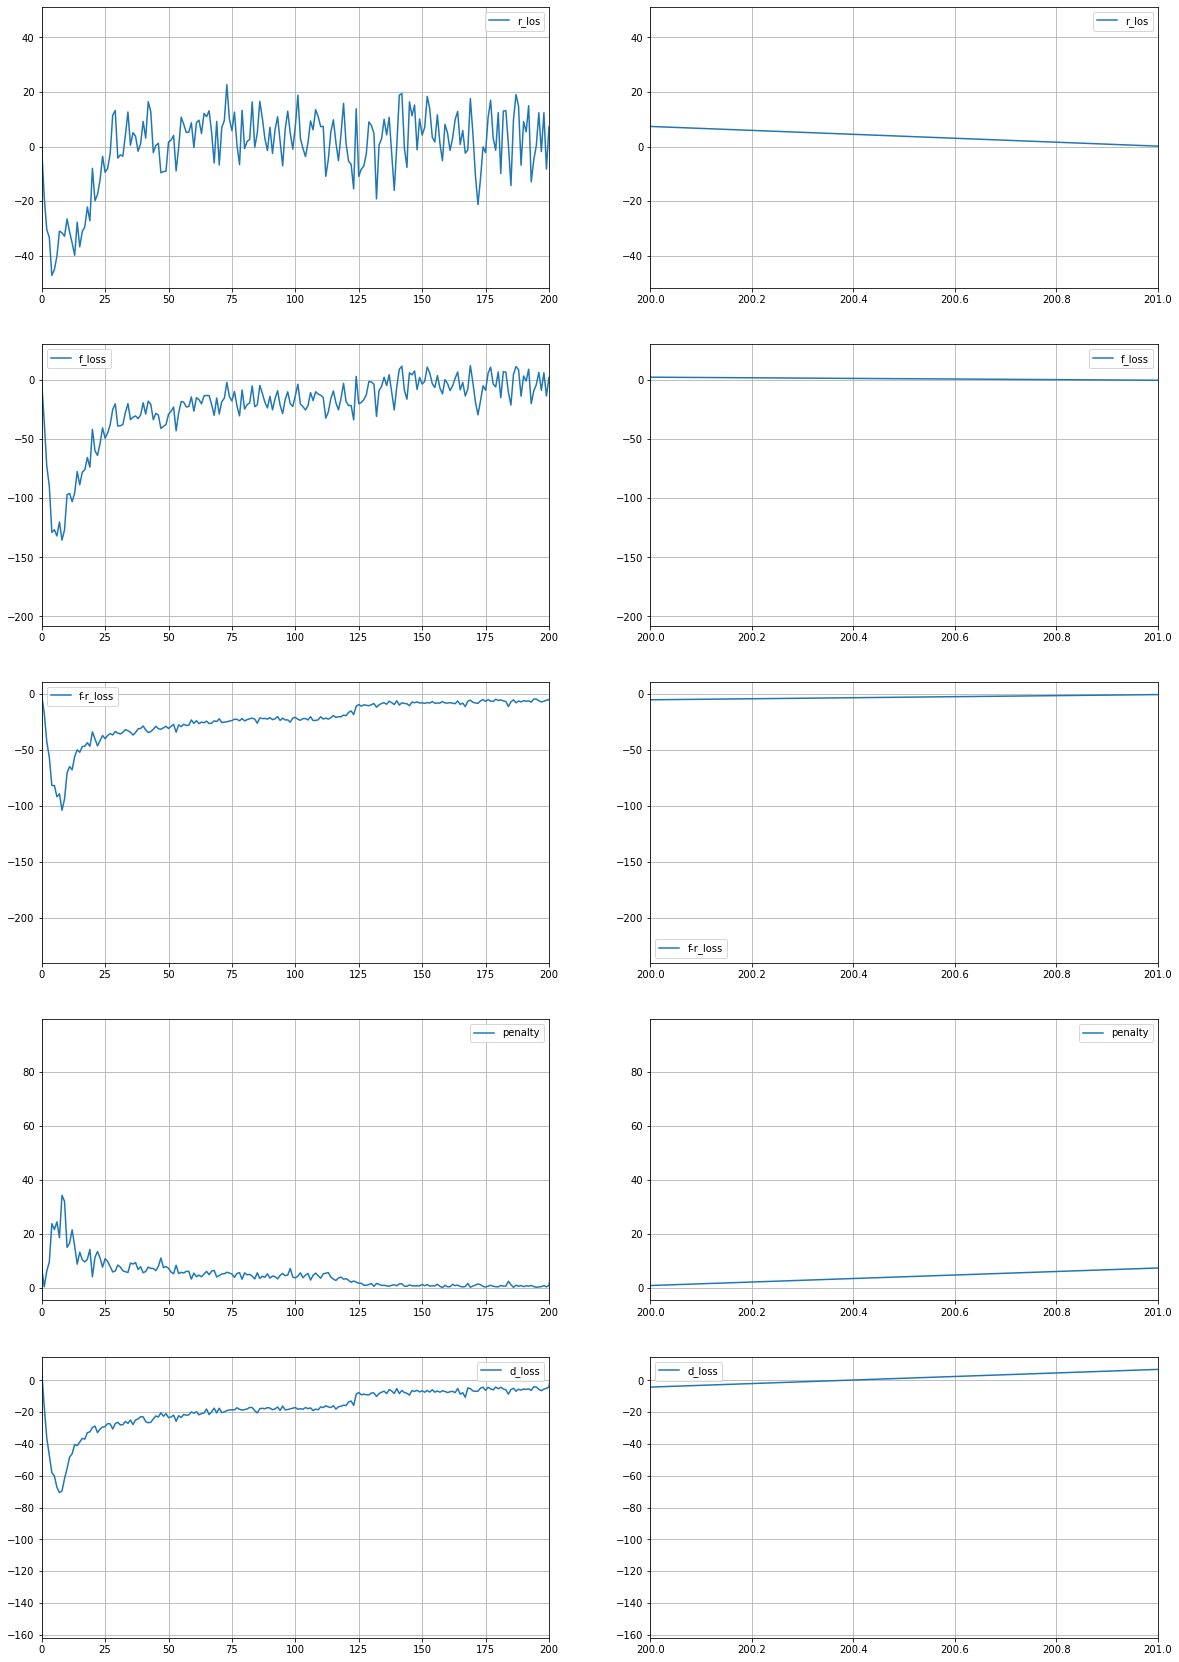

In [18]:
generator = build_generator()
discriminator = build_discriminator()
G_train, D_train = build_WGANgp(generator, discriminator)
train(x_train)

## Submit

In [20]:
if os.path.exists(DIRout):
    shutil.rmtree(DIRout)
if not os.path.exists(DIRout):
    os.mkdir(DIRout)

In [21]:
# generate images for submit
n = 50
batch = 64
for i in tqdm(range(0, n, batch)):
    z = np.random.normal(0,1,size=(batch, z_dim))
    g_imgs = generator.predict(z)
    imgs = g_imgs * 127.5 + 127.5
    for j in range(batch):
        img = image.array_to_img(imgs[j])      # ndarray → PIL 
        img.save(os.path.join(DIRout, 'image_' + str(i+j+1).zfill(5) + '.png'))
        if i+j+1 == n:
            break
print(len(os.listdir(DIRout)))

100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

50


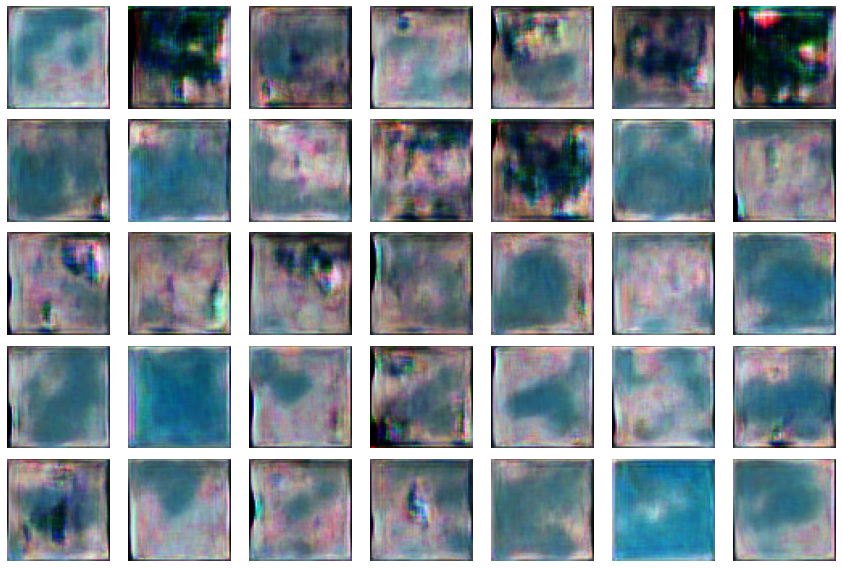

In [22]:

sumple_images(g_imgs, rows=5, cols=7, figsize=(12,8))

In [ ]:
def build_classifier():
    classifier = Sequential()
    classifier.add(Conv2D(32, (3, 3), input_shape=(img_size, img_size, 3),strides=2))
    classifier.add(Activation('relu'))

    classifier.add(Conv2D(64, (3, 3), input_shape=(img_size, img_size, 3),strides=2))
    classifier.add(Activation('relu'))

    classifier.add(Conv2D(128, (3, 3), input_shape=(img_size, img_size, 3),strides=2))
    classifier.add(Activation('relu'))

    classifier.add(Flatten())
    classifier.add(Dense(64))
    classifier.add(Activation('relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(1))
    classifier.add(Activation('sigmoid'))

    classifier.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    classifier.summary()
    return classifier


In [ ]:
np.concatenate([np.zeros(10),np.ones(10)])

In [ ]:
def train_classifier(x_train_land,x_train_water,iteration=200):
    x=np.vstack([x_train_land,x_train_water])
    y=np.concatenate([np.zeros(x_train_land.shape[0]),np.ones(x_train_water.shape[0])])
    x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True)
    print(x_train.shape,y_train.shape)
    classifier1=build_classifier()
    classifier.fit(x_train,y_train,validation_data=(x_test, y_test))
    y_pred=[int(p>0.5) for p in classifier.predict(x_test)]
    print(confusion_matrix(y_test,y_pred))
    return classifier

In [ ]:
train_classifier(x_train_land,x_train_water)